In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC
from sklearn.ensemble import ExtraTreesClassifier, AdaBoostClassifier, GradientBoostingClassifier, RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
import pipeline
from roc_analysis import ROCAnalysisScorer

### Loading the Datasets

In [197]:
df = pd.DataFrame.from_csv("../data/train_risk.csv", index_col=False)
test = pd.DataFrame.from_csv("../data/test_risk.csv", index_col=False)
X, y = df[df.columns[:-1]], df[df.columns[-1]]

## Analysing the Data

Looking at the difference between the number of positive and negative samples in the dataset shows that there are more negative examples than positive examples. Only 28% of all samples are of the positive class.

In [3]:
def class_balance_summary(y):
    """ Summarise the imbalance in the dataset"""
    total_size = y.size
    negative_class = y[y == 0].size
    positive_class = y[y > 0].size
    ratio = positive_class / float(positive_class + negative_class)

    print "Total number of samples: %d" % total_size
    print "Number of positive samples: %d" % positive_class
    print "Number of negative samples: %d" % negative_class
    print "Ratio of positive to total number of samples: %.2f" % ratio


class_balance_summary(y)

Total number of samples: 300
Number of positive samples: 84
Number of negative samples: 216
Ratio of positive to total number of samples: 0.28


Some initial observations about the data before it is preprocessed:
 - PRE32 is all zeros. This can be removed
 - PRE14 looks catagorical. Should be split into multiple binary variables
 - DGN looks catagorical. As above.
 - PRE5 looks to have some outliers. See box plot below. Potentially remove or split into two extra variable?

In [4]:
X.head()

,DGN,PRE4,PRE5,PRE6,PRE7,PRE8,PRE9,PRE10,PRE11,PRE14,PRE17,PRE19,PRE25,PRE30,PRE32,AGE
0,3,2.08,1.52,1,0,0,0,1,0,4,0,0,0,1,0,49
1,3,4.36,3.76,0,0,0,0,0,0,1,0,0,0,1,0,72
2,3,3.52,2.28,0,0,0,0,0,0,3,0,0,0,1,0,51
3,3,3.36,2.67,1,0,0,0,1,0,1,0,0,0,1,0,72
4,3,3.56,2.80,0,0,0,0,0,0,2,0,0,0,0,0,69


Box plot below shows the outliers in PRE5. It is worth noting that all of these outliers are of the negative class. This variable is the volume that can be exhaled in one second given full inhilation. It is likely that these values are therefore errors in reporting as it is unlikely that humans can exhale such a large volume so quickly.

11     0
25     0
101    0
108    0
122    0
212    0
240    0
Name: Risk1Yr, dtype: int64


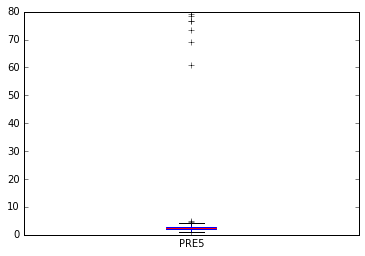

In [5]:
# X.PRE5.plot(kind='box')
X.PRE5.plot(kind='box')
print y[X.PRE5 > 30 ]

## Preprocessing

Create a new matrix of preprocessed features. This will encode catagorical data as one hot vectors, remove outliers, and normalise the data.  

In [198]:
from sklearn import preprocessing

def encode_onehot(x_data, column_name, digitize=False):
    """ Encode a catagorical column from a data frame into a data frame of one hot features"""
    data = x_data[[column_name]]

    if digitize:
        data = np.digitize(data, np.arange(data.min(), data.max(), 10))
    
    enc = preprocessing.OneHotEncoder()
    features = enc.fit_transform(data).toarray()
    names = ['%s_%d' % (column_name, i) for i in enc.active_features_]
    features = pd.DataFrame(features, columns=names, index=x_data.index)
    return features


def preprocess(x_data, y_data=None):
    # drop zero var PRE32
    Xp = x_data.drop("PRE32", axis=1)
    
    # remove outliers
    if y_data is not None: 
        mask = Xp.PRE5 < 30
        Xp = Xp.loc[mask]
        Yp = y_data.copy()
        Yp = Yp.loc[mask]
    else:
        Yp = None
    
    # encode catagorical data as one hot vectors
    one_hot_names = ["DGN"]
    encoded = map(lambda name: encode_onehot(Xp, name), one_hot_names)
    #combine into a single data frame
    new_features = pd.concat(encoded, axis=1)

    # drop the catagorical variables that have been encoded
    Xp.drop(["DGN"], inplace=True, axis=1)
    # add new features
    Xp = pd.concat([Xp, new_features], axis=1)

    return Xp, Yp

Xp, Yp = preprocess(X, y)
Xp.head()

,PRE4,PRE5,PRE6,PRE7,PRE8,PRE9,PRE10,PRE11,PRE14,PRE17,...,PRE25,PRE30,AGE,DGN_1,DGN_2,DGN_3,DGN_4,DGN_5,DGN_6,DGN_8
0,2.08,1.52,1,0,0,0,1,0,4,0,...,0,1,49,0.0,0.0,1.0,0.0,0.0,0.0,0.0
1,4.36,3.76,0,0,0,0,0,0,1,0,...,0,1,72,0.0,0.0,1.0,0.0,0.0,0.0,0.0
2,3.52,2.28,0,0,0,0,0,0,3,0,...,0,1,51,0.0,0.0,1.0,0.0,0.0,0.0,0.0
3,3.36,2.67,1,0,0,0,1,0,1,0,...,0,1,72,0.0,0.0,1.0,0.0,0.0,0.0,0.0
4,3.56,2.80,0,0,0,0,0,0,2,0,...,0,0,69,0.0,0.0,1.0,0.0,0.0,0.0,0.0


Measure the effectiveness of each feature using the variable importance measure from a Random Forest

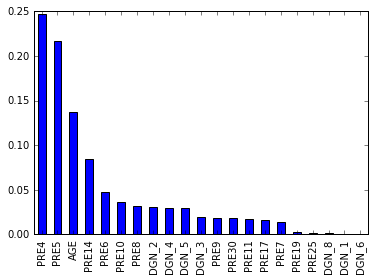

In [10]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler

def measure_importance(x_data, y_data):
    rf_selector = RandomForestClassifier(criterion='gini', class_weight='balanced')
    rf_selector.fit(StandardScaler().fit_transform(x_data), y_data)
    feature_importance = pd.Series(rf_selector.feature_importances_, index=x_data.columns).sort_values(ascending=False)
    feature_importance.plot(kind='bar')
    return feature_importance

feature_importance = measure_importance(Xp, Yp)
Xp.drop(feature_importance[feature_importance == 0].index, inplace=True, axis=1)

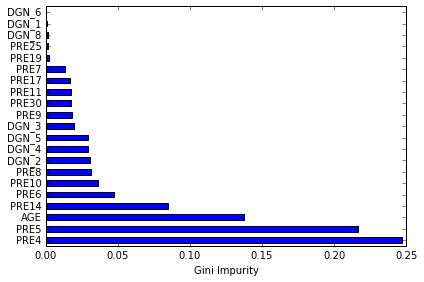

In [11]:
feature_importance.plot(kind='barh')
plt.xlabel('Gini Impurity')
plt.tight_layout()
plt.savefig("img/feature_importance.png")

The numerical features appear to be the most important ones. Plot a scatter plot matrix to see how the how the correlate with each other

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x10f406750>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x10f3c7750>]], dtype=object)

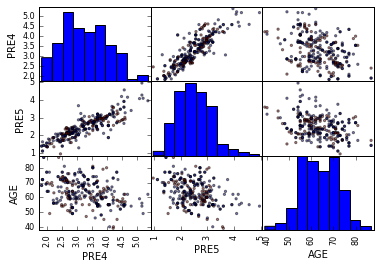

In [12]:
pd.tools.plotting.scatter_matrix(Xp[['PRE4', 'PRE5', 'AGE']], c=Yp)

## Tuning Model Parameters

Given the current status of the data tune the model parameters to it before we evalute the overall performance. Note that all of the tuning presented here is orientated towards obtaining the highest AUC score. Other metrics might be more desirable given the problem domain, but AUC is the measurement used for assignment points.

In [13]:
from sklearn import cross_validation
skf = cross_validation.StratifiedKFold(Yp, n_folds=5)

### Random Forest Tuning
Run a grid search over a range of parameters for a Random Forest. The dataset is small enough that we can do them all at once. ```n_estimators``` is neglected because this should always improve as it is increased so we should attempt to make it as large as possible subject to lack of improvement

In [3835]:
param_grid = {"max_depth": range(2, 20, 3),
              "max_features": range(2, 20, 3),
              "min_samples_split": range(1, 5),
              "min_samples_leaf": range(1, 5),
             }

rf = RandomForestClassifier(class_weight='balanced', n_estimators=50, random_state=50)
rf_clf = grid_search.GridSearchCV(rf, param_grid, n_jobs=-1, cv=skf, scoring='roc_auc')
rf_clf.fit(Xp, Yp)

GridSearchCV(cv=sklearn.cross_validation.StratifiedKFold(labels=[1 0 ..., 0 0], n_folds=5, shuffle=False, random_state=None),
       error_score='raise',
       estimator=RandomForestClassifier(bootstrap=True, class_weight='balanced',
            criterion='gini', max_depth=None, max_features='auto',
            max_leaf_nodes=None, min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=50, n_jobs=1,
            oob_score=False, random_state=50, verbose=0, warm_start=False),
       fit_params={}, iid=True, n_jobs=-1,
       param_grid={'max_features': [2, 5, 8, 11, 14, 17], 'min_samples_split': [1, 2, 3, 4], 'max_depth': [1, 4, 7, 10, 13, 16, 19], 'min_samples_leaf': [1, 2, 3, 4]},
       pre_dispatch='2*n_jobs', refit=True, scoring='roc_auc', verbose=0)

In [3836]:
print rf_clf.best_params_

{'max_features': 5, 'min_samples_split': 1, 'max_depth': 16, 'min_samples_leaf': 1}


Now take a look at the number of estimators and see where performance begins to level off.

In [3838]:
param_grid = {"n_estimators": range(50, 500, 50)}
const_params = {'max_features': 1, 'min_samples_split': 1, 'max_depth': 16, 'min_samples_leaf': 1}

rf = RandomForestClassifier(class_weight='balanced', n_estimators=50, random_state=50, **const_params)
rf_clf2 = grid_search.GridSearchCV(rf, param_grid, n_jobs=-1, cv=skf, scoring='roc_auc')
rf_clf2.fit(Xp, Yp)

GridSearchCV(cv=sklearn.cross_validation.StratifiedKFold(labels=[1 0 ..., 0 0], n_folds=5, shuffle=False, random_state=None),
       error_score='raise',
       estimator=RandomForestClassifier(bootstrap=True, class_weight='balanced',
            criterion='gini', max_depth=16, max_features=1,
            max_leaf_nodes=None, min_samples_leaf=1, min_samples_split=1,
            min_weight_fraction_leaf=0.0, n_estimators=50, n_jobs=1,
            oob_score=False, random_state=50, verbose=0, warm_start=False),
       fit_params={}, iid=True, n_jobs=-1,
       param_grid={'n_estimators': [50, 100, 150, 200, 250, 300, 350, 400, 450]},
       pre_dispatch='2*n_jobs', refit=True, scoring='roc_auc', verbose=0)

The best parameters for ```n_estimators``` levels off after around 300 estimators

{'n_estimators': 100}
0.89217869367


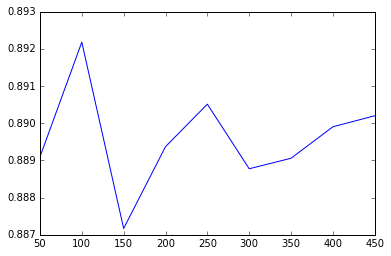

In [3840]:
plt.plot([d[0]['n_estimators'] for d in rf_clf2.grid_scores_], [d[1] for d in rf_clf2.grid_scores_])
print rf_clf2.best_params_
print rf_clf2.best_score_

In [3725]:
rf_clf2.best_estimator_.get_params()

{'bootstrap': True,
 'class_weight': 'balanced',
 'criterion': 'gini',
 'max_depth': 16,
 'max_features': 1,
 'max_leaf_nodes': None,
 'min_samples_leaf': 1,
 'min_samples_split': 1,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 300,
 'n_jobs': 1,
 'oob_score': False,
 'random_state': 50,
 'verbose': 0,
 'warm_start': False}

### Gradient Boosting Tuning

Gradient boosting is difficult to tune effectively. [This guide](http://www.analyticsvidhya.com/blog/2016/02/complete-guide-parameter-tuning-gradient-boosting-gbm-python/) suggests starting by fixing the learning rate and number of estimators to a relatively low number in order to tune the other hyperparameters. After they are optimised the learning rate is gradually lowered and the number of estimators increased until we find convergance on the optimum parameters

In [3587]:
param_grid = [
   {'n_estimators': range(20,150,10)}
]

const_params = {'learning_rate': 0.1, 'min_samples_split': 1, 'min_samples_leaf': 3, 'max_depth': 8, 'max_features': 'sqrt', 'subsample': 0.8}
gbc = GradientBoostingClassifier(random_state=50, **const_params)

gbc_clf = grid_search.GridSearchCV(gbc, param_grid, cv=skf, scoring='roc_auc')
gbc_clf.fit(Xp, Yp)

GridSearchCV(cv=sklearn.cross_validation.StratifiedKFold(labels=[1 0 ..., 0 0], n_folds=5, shuffle=False, random_state=None),
       error_score='raise',
       estimator=GradientBoostingClassifier(init=None, learning_rate=0.1, loss='deviance',
              max_depth=8, max_features='sqrt', max_leaf_nodes=None,
              min_samples_leaf=3, min_samples_split=1,
              min_weight_fraction_leaf=0.0, n_estimators=100,
              presort='auto', random_state=50, subsample=0.8, verbose=0,
              warm_start=False),
       fit_params={}, iid=True, n_jobs=1,
       param_grid=[{'n_estimators': [20, 30, 40, 50, 60, 70, 80, 90, 100, 110, 120, 130, 140]}],
       pre_dispatch='2*n_jobs', refit=True, scoring='roc_auc', verbose=0)

```n_estimators``` plateaus at around 100, so we'll use this instead of the optimum as less trees == quicker training and we'll need to decrease the learning rate and increase the number of trees later in the tuning anyway.

{'n_estimators': 120}


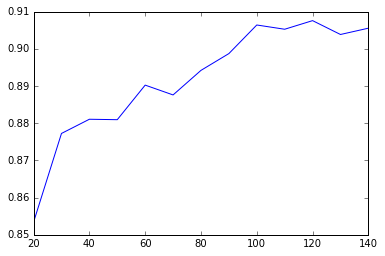

In [3588]:
plt.plot([d[0]['n_estimators'] for d in gbc_clf.grid_scores_], [d[1] for d in gbc_clf.grid_scores_])
print gbc_clf.best_params_

Now tune the ```max_depth``` and the ```min_samples_split``` parameters.

In [3594]:
const_params = {'n_estimators':100, 
                'learning_rate': 0.1, 
                'min_samples_leaf': 3, 
                'max_features': 'sqrt', 
                'subsample': 0.8
               }

param_grid = [
    {'max_depth':range(5,16,2), 'min_samples_split':range(1, 20, 3)}
]


gbc = GradientBoostingClassifier(random_state=50, **const_params)
gbc_clf = grid_search.GridSearchCV(gbc, param_grid, cv=skf, scoring='roc_auc')
gbc_clf.fit(Xp, Yp)

GridSearchCV(cv=sklearn.cross_validation.StratifiedKFold(labels=[1 0 ..., 0 0], n_folds=5, shuffle=False, random_state=None),
       error_score='raise',
       estimator=GradientBoostingClassifier(init=None, learning_rate=0.1, loss='deviance',
              max_depth=3, max_features='sqrt', max_leaf_nodes=None,
              min_samples_leaf=3, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=100,
              presort='auto', random_state=50, subsample=0.8, verbose=0,
              warm_start=False),
       fit_params={}, iid=True, n_jobs=1,
       param_grid=[{'min_samples_split': [1, 4, 7, 10, 13, 16, 19], 'max_depth': [5, 7, 9, 11, 13, 15]}],
       pre_dispatch='2*n_jobs', refit=True, scoring='roc_auc', verbose=0)

In [3595]:
print gbc_clf.best_params_
gbc_clf.grid_scores_

{'min_samples_split': 7, 'max_depth': 9}


[mean: 0.88220, std: 0.04754, params: {'min_samples_split': 1, 'max_depth': 5},
 mean: 0.88220, std: 0.04754, params: {'min_samples_split': 4, 'max_depth': 5},
 mean: 0.87967, std: 0.04768, params: {'min_samples_split': 7, 'max_depth': 5},
 mean: 0.89035, std: 0.04813, params: {'min_samples_split': 10, 'max_depth': 5},
 mean: 0.87719, std: 0.05057, params: {'min_samples_split': 13, 'max_depth': 5},
 mean: 0.87051, std: 0.05437, params: {'min_samples_split': 16, 'max_depth': 5},
 mean: 0.86807, std: 0.05291, params: {'min_samples_split': 19, 'max_depth': 5},
 mean: 0.89821, std: 0.04452, params: {'min_samples_split': 1, 'max_depth': 7},
 mean: 0.89821, std: 0.04452, params: {'min_samples_split': 4, 'max_depth': 7},
 mean: 0.89473, std: 0.04767, params: {'min_samples_split': 7, 'max_depth': 7},
 mean: 0.89704, std: 0.04538, params: {'min_samples_split': 10, 'max_depth': 7},
 mean: 0.89991, std: 0.03903, params: {'min_samples_split': 13, 'max_depth': 7},
 mean: 0.88864, std: 0.05408, para

Now train ```max_features```:

In [3600]:
const_params = {'n_estimators':100, 
                'learning_rate': 0.1, 
                'min_samples_leaf': 3, 
                'max_features': 'sqrt',
                'max_depth': 9,
                'min_samples_split': 7,
                'subsample': 0.8
               }

param_grid = [
    {'max_features':range(5,20,2)}
]


gbc = GradientBoostingClassifier(random_state=50, **const_params)
gbc_clf = grid_search.GridSearchCV(gbc, param_grid, cv=skf, scoring='roc_auc')
gbc_clf.fit(Xp, Yp)

GridSearchCV(cv=sklearn.cross_validation.StratifiedKFold(labels=[1 0 ..., 0 0], n_folds=5, shuffle=False, random_state=None),
       error_score='raise',
       estimator=GradientBoostingClassifier(init=None, learning_rate=0.1, loss='deviance',
              max_depth=9, max_features='sqrt', max_leaf_nodes=None,
              min_samples_leaf=3, min_samples_split=7,
              min_weight_fraction_leaf=0.0, n_estimators=100,
              presort='auto', random_state=50, subsample=0.8, verbose=0,
              warm_start=False),
       fit_params={}, iid=True, n_jobs=1,
       param_grid=[{'max_features': [5, 7, 9, 11, 13, 15, 17, 19]}],
       pre_dispatch='2*n_jobs', refit=True, scoring='roc_auc', verbose=0)

{'max_features': 11}


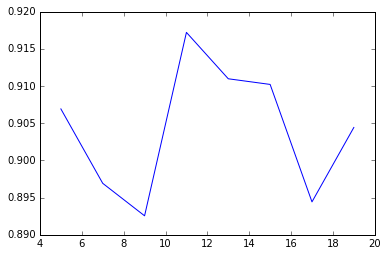

In [3601]:
plt.plot([d[0]['max_features'] for d in gbc_clf.grid_scores_], [d[1] for d in gbc_clf.grid_scores_])
print gbc_clf.best_params_

Now train to tune the ```subsample``` rate.

In [3603]:
const_params = {'n_estimators':100, 
                'learning_rate': 0.1, 
                'min_samples_leaf': 3, 
                'max_features': 'sqrt',
                'max_depth': 9,
                'min_samples_split': 7,
                'max_features': 11,
                'subsample': 0.8
               }

param_grid = [
    {'subsample': [0.6, 0.7, 0.75, 0.8, 0.85, 0.9]}
]


gbc = GradientBoostingClassifier(random_state=50, **const_params)
gbc_clf = grid_search.GridSearchCV(gbc, param_grid, cv=skf, scoring='roc_auc')
gbc_clf.fit(Xp, Yp)

GridSearchCV(cv=sklearn.cross_validation.StratifiedKFold(labels=[1 0 ..., 0 0], n_folds=5, shuffle=False, random_state=None),
       error_score='raise',
       estimator=GradientBoostingClassifier(init=None, learning_rate=0.1, loss='deviance',
              max_depth=9, max_features=11, max_leaf_nodes=None,
              min_samples_leaf=3, min_samples_split=7,
              min_weight_fraction_leaf=0.0, n_estimators=100,
              presort='auto', random_state=50, subsample=0.8, verbose=0,
              warm_start=False),
       fit_params={}, iid=True, n_jobs=1,
       param_grid=[{'subsample': [0.6, 0.7, 0.75, 0.8, 0.85, 0.9]}],
       pre_dispatch='2*n_jobs', refit=True, scoring='roc_auc', verbose=0)

{'subsample': 0.8}


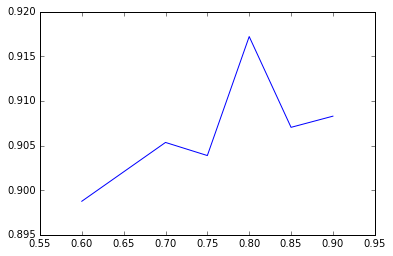

In [3604]:
plt.plot([d[0]['subsample'] for d in gbc_clf.grid_scores_], [d[1] for d in gbc_clf.grid_scores_])
print gbc_clf.best_params_

Now cross validate with all the parameters set:

In [3614]:
const_params = { 
                'min_samples_leaf': 1, 
                'min_samples_split': 7, 
                'max_depth': 9, 
                'max_features': 11, 
                'subsample': 0.8
               }

param_grid = [
    {'n_estimators': [100], 'learning_rate': [0.1]},
    {'n_estimators': [200], 'learning_rate': [0.05]},
    {'n_estimators': [1000], 'learning_rate': [0.01]},
    {'n_estimators': [1500], 'learning_rate': [0.005]},
]

gbc = GradientBoostingClassifier(random_state=50, **const_params)

gbc_clf = grid_search.GridSearchCV(gbc, param_grid, cv=skf, scoring='roc_auc')
gbc_clf.fit(Xp, Yp)

GridSearchCV(cv=sklearn.cross_validation.StratifiedKFold(labels=[1 0 ..., 0 0], n_folds=5, shuffle=False, random_state=None),
       error_score='raise',
       estimator=GradientBoostingClassifier(init=None, learning_rate=0.1, loss='deviance',
              max_depth=9, max_features=11, max_leaf_nodes=None,
              min_samples_leaf=1, min_samples_split=7,
              min_weight_fraction_leaf=0.0, n_estimators=100,
              presort='auto', random_state=50, subsample=0.8, verbose=0,
              warm_start=False),
       fit_params={}, iid=True, n_jobs=1,
       param_grid=[{'n_estimators': [100], 'learning_rate': [0.1]}, {'n_estimators': [200], 'learning_rate': [0.05]}, {'n_estimators': [1000], 'learning_rate': [0.01]}, {'n_estimators': [1500], 'learning_rate': [0.005]}],
       pre_dispatch='2*n_jobs', refit=True, scoring='roc_auc', verbose=0)

In [3718]:
print gbc_clf.best_params_
gbc_clf.grid_scores_

{'n_estimators': 1000, 'learning_rate': 0.01}


[mean: 0.90460, std: 0.03726, params: {'n_estimators': 100, 'learning_rate': 0.1},
 mean: 0.90313, std: 0.03876, params: {'n_estimators': 200, 'learning_rate': 0.05},
 mean: 0.90830, std: 0.03889, params: {'n_estimators': 1000, 'learning_rate': 0.01},
 mean: 0.90370, std: 0.03988, params: {'n_estimators': 1500, 'learning_rate': 0.005}]

In [3854]:
p = pd.DataFrame(gbc_clf.best_estimator_.get_params(), index=['Value']).T
p.index.name = "Parameter"
print p.to_latex()

\begin{tabular}{ll}
\toprule
{} &     Value \\
Parameter                &           \\
\midrule
init                     &      None \\
learning\_rate            &      0.01 \\
loss                     &  deviance \\
max\_depth                &         9 \\
max\_features             &        11 \\
max\_leaf\_nodes           &      None \\
min\_samples\_leaf         &         1 \\
min\_samples\_split        &         7 \\
min\_weight\_fraction\_leaf &         0 \\
n\_estimators             &      1000 \\
presort                  &      auto \\
random\_state             &        50 \\
subsample                &       0.8 \\
verbose                  &         0 \\
warm\_start               &     False \\
\bottomrule
\end{tabular}



### AdaBoost Tuning
Perhaps the easiest train due to a fairly limited number of parameters. Adjusting the ```max_depth``` suggests that 4 appears to be roughly the best option for the depth of the decision trees.

In [3764]:
param_grid = {"n_estimators": range(50, 1000, 50), 'learning_rate': [0.1, 0.5, 0.01, 0.005]}

dt = DecisionTreeClassifier(class_weight='balanced', max_depth=4)
adb = AdaBoostClassifier(dt)
adb_clf = grid_search.GridSearchCV(adb, param_grid, n_jobs=-1, cv=skf, scoring='roc_auc')
adb_clf.fit(Xp, Yp)

GridSearchCV(cv=sklearn.cross_validation.StratifiedKFold(labels=[1 0 ..., 0 0], n_folds=5, shuffle=False, random_state=None),
       error_score='raise',
       estimator=AdaBoostClassifier(algorithm='SAMME.R',
          base_estimator=DecisionTreeClassifier(class_weight='balanced', criterion='gini', max_depth=4,
            max_features=None, max_leaf_nodes=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=None, splitter='best'),
          learning_rate=0.1, n_estimators=50, random_state=None),
       fit_params={}, iid=True, n_jobs=-1,
       param_grid={'n_estimators': [50, 100, 150, 200, 250, 300, 350, 400, 450, 500, 550, 600, 650, 700, 750, 800, 850, 900, 950], 'learning_rate': [0.1, 0.5, 0.01, 0.005]},
       pre_dispatch='2*n_jobs', refit=True, scoring='roc_auc', verbose=0)

In [3781]:
print adb_clf.best_params_
print adb_clf.best_score_
adb_clf.grid_scores_

{'n_estimators': 400, 'learning_rate': 0.5}
0.898625942927


[mean: 0.81604, std: 0.09086, params: {'n_estimators': 50, 'learning_rate': 0.1},
 mean: 0.82380, std: 0.06706, params: {'n_estimators': 100, 'learning_rate': 0.1},
 mean: 0.82011, std: 0.06168, params: {'n_estimators': 150, 'learning_rate': 0.1},
 mean: 0.83886, std: 0.05610, params: {'n_estimators': 200, 'learning_rate': 0.1},
 mean: 0.82707, std: 0.05400, params: {'n_estimators': 250, 'learning_rate': 0.1},
 mean: 0.83609, std: 0.05725, params: {'n_estimators': 300, 'learning_rate': 0.1},
 mean: 0.85398, std: 0.05896, params: {'n_estimators': 350, 'learning_rate': 0.1},
 mean: 0.83988, std: 0.06063, params: {'n_estimators': 400, 'learning_rate': 0.1},
 mean: 0.85468, std: 0.04492, params: {'n_estimators': 450, 'learning_rate': 0.1},
 mean: 0.84810, std: 0.03408, params: {'n_estimators': 500, 'learning_rate': 0.1},
 mean: 0.84320, std: 0.03759, params: {'n_estimators': 550, 'learning_rate': 0.1},
 mean: 0.86687, std: 0.06168, params: {'n_estimators': 600, 'learning_rate': 0.1},
 mean

### Extremely Random Trees Tuning

This is very similar to Random Forests. In fact we will start with the same parameter set for the grid search.

In [3800]:
param_grid = {"max_depth": range(2, 20, 3),
              "max_features": range(2, 20, 3),
              "min_samples_split": range(1, 5),
              "min_samples_leaf": range(1, 5),
             }
etc = ExtraTreesClassifier(class_weight='balanced', bootstrap=True, n_estimators=50, random_state=50)
etc_clf = grid_search.GridSearchCV(etc, param_grid, n_jobs=-1, cv=skf, scoring='roc_auc')
etc_clf.fit(Xp, Yp)

GridSearchCV(cv=sklearn.cross_validation.StratifiedKFold(labels=[1 0 ..., 0 0], n_folds=5, shuffle=False, random_state=None),
       error_score='raise',
       estimator=ExtraTreesClassifier(bootstrap=True, class_weight='balanced',
           criterion='gini', max_depth=None, max_features='auto',
           max_leaf_nodes=None, min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=50, n_jobs=1,
           oob_score=False, random_state=50, verbose=0, warm_start=False),
       fit_params={}, iid=True, n_jobs=-1,
       param_grid={'max_features': [1, 4, 7, 10, 13, 16, 19], 'min_samples_split': [1, 2, 3, 4], 'max_depth': [1, 4, 7, 10, 13, 16, 19], 'min_samples_leaf': [1, 2, 3, 4]},
       pre_dispatch='2*n_jobs', refit=True, scoring='roc_auc', verbose=0)

In [3801]:
print etc_clf.best_params_
print etc_clf.best_score_

{'max_features': 16, 'min_samples_split': 1, 'max_depth': 19, 'min_samples_leaf': 1}
0.887051406553


Now check increasing the number of estimators and find the drop off point

In [3805]:
param_grid = {"n_estimators": range(50, 500, 50)}
const_params = {'max_features': 16, 'min_samples_split': 1, 'max_depth': 19, 'min_samples_leaf': 1}

etc = ExtraTreesClassifier(class_weight='balanced', bootstrap=True, random_state=50, **const_params)
etc_clf2 = grid_search.GridSearchCV(etc, param_grid, n_jobs=-1, cv=skf, scoring='roc_auc')
etc_clf2.fit(Xp, Yp)

GridSearchCV(cv=sklearn.cross_validation.StratifiedKFold(labels=[1 0 ..., 0 0], n_folds=5, shuffle=False, random_state=None),
       error_score='raise',
       estimator=ExtraTreesClassifier(bootstrap=True, class_weight='balanced',
           criterion='gini', max_depth=19, max_features=16,
           max_leaf_nodes=None, min_samples_leaf=1, min_samples_split=1,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
           oob_score=False, random_state=50, verbose=0, warm_start=False),
       fit_params={}, iid=True, n_jobs=-1,
       param_grid={'n_estimators': [50, 100, 150, 200, 250, 300, 350, 400, 450]},
       pre_dispatch='2*n_jobs', refit=True, scoring='roc_auc', verbose=0)

{'n_estimators': 200}
0.890377576778


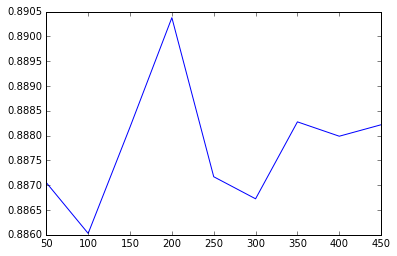

In [3806]:
plt.plot([d[0]['n_estimators'] for d in etc_clf2.grid_scores_], [d[1] for d in etc_clf2.grid_scores_])
print etc_clf2.best_params_
print etc_clf2.best_score_

In [3807]:
etc_clf2.best_estimator_.get_params()

{'bootstrap': True,
 'class_weight': 'balanced',
 'criterion': 'gini',
 'max_depth': 19,
 'max_features': 16,
 'max_leaf_nodes': None,
 'min_samples_leaf': 1,
 'min_samples_split': 1,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 200,
 'n_jobs': 1,
 'oob_score': False,
 'random_state': 50,
 'verbose': 0,
 'warm_start': False}

## Model Performance
Test the performance of each of the models on the preprocessed dataset before trying any more complicated feature engineering/resampling. This should give us some rough baseline AUC measures to work with. Firstly, set up the models. This creates a set of pipelines for each of the models we want to use. 

In [178]:
scaler = preprocessing.StandardScaler()

# set up classifier objects
knn = KNeighborsClassifier(n_neighbors=5, weights='distance')
dct = DecisionTreeClassifier(class_weight='balanced', max_depth=4)
abt = AdaBoostClassifier(dct, n_estimators=400, learning_rate=0.5)

gbc_params = { 
    'min_samples_leaf': 1, 
    'min_samples_split': 7, 
    'max_depth': 9, 
    'max_features': 11, 
    'subsample': 0.8,
    'n_estimators': 1000,
    'learning_rate': 0.01
}
gbc = GradientBoostingClassifier(**gbc_params)

exf_params = {
    'bootstrap': False,
    'class_weight': 'balanced',
    'criterion': 'gini',
    'max_depth': 19,
    'max_features': 16,
    'max_leaf_nodes': None,
    'min_samples_leaf': 1,
    'min_samples_split': 1,
    'min_weight_fraction_leaf': 0.0,
    'n_estimators': 200,
    'n_jobs': 1,
    'oob_score': False,
    'random_state': 50,
    'verbose': 0,
    'warm_start': False
}


exf = ExtraTreesClassifier(**exf_params)

rf_params = {
    'bootstrap': True,
    'class_weight': 'balanced',
    'criterion': 'gini',
    'max_depth': 16,
    'max_features': 1,
    'max_leaf_nodes': None,
    'min_samples_leaf': 1,
    'min_samples_split': 1,
    'min_weight_fraction_leaf': 0.0,
    'n_estimators': 300
}
rf_balanced = RandomForestClassifier(**rf_params)

# create pipelines for each model
abt_pipe = Pipeline([('scaler', scaler), ('AdaBoost', abt)])
exf_pipe = Pipeline([('scaler', scaler), ('ExtraTrees', exf)])
gbc_pipe = Pipeline([('scaler', scaler), ('GradientBoostingClassifer', gbc)])
rfs_pipe = Pipeline([('scaler', scaler), ('RandomForest', rf_balanced)])

# create list of model data
models = [
    {'name': 'AdaBoost', 'model': abt_pipe},
    {'name': 'ExtraTrees', 'model': exf_pipe},
    {'name': 'RandomForest', 'model': rfs_pipe},
    {'name': 'GradientBoost', 'model': gbc_pipe},
]

# set the same training set for all models.
# this is just the preprocessed dataset.
for model in models:
    model['train_data'] = (Xp, Yp)

Define some useful helper functions for summarising the results of k-fold/monte carlo cross validation

In [150]:
def f_score_summary(scorers):
    """ Create a summary of the average f-scores for all folds/trials"""
    series = []
    columns = []
    for key, scorer in scorers.iteritems():
        f_scores = [np.mean(scorer.f1scores_), np.mean(scorer.f2scores_), np.mean(scorer.fhalf_scores_)]
        s = pd.Series(f_scores, index=['F1', 'F2', 'F0.5'])
        series.append(s)
        columns.append(key)
    
    frame = pd.concat(series, axis = 1)    
    frame.columns = columns
    return frame

def summarise_scorers(scorers):
    """ Create a summary of the scorers AUCs for all folds/trials"""
    names = [name for name in scorers.keys()]
    aucs = [scorer.aucs_ for scorer in scorers.values()]
    aucs = pd.DataFrame(np.array(aucs).T, columns=names)
    return aucs.describe()

Perform n iterations of k fold cross validation. Here I am using 10 iterations and 5 folds at each iteration.

In [151]:
scorers = pipeline.repeated_cross_fold_validation(models, n=10, k=5)

Plot an ROC curve and the mean AUCs.

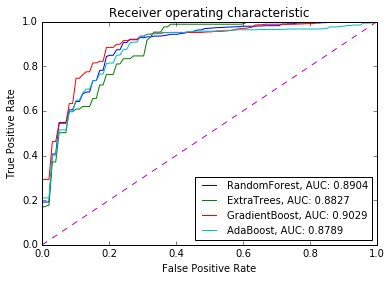

In [153]:
for key, scorer in scorers.iteritems():
    scorer.plot_roc_curve(mean_label=key, mean_line=True, show_all=False)

plt.plot(np.arange(0,1.1, 0.1), np.arange(0,1.1, 0.1), '--')
plt.savefig("img/roc_cv.png")

Plot bar chart of the F2 scores

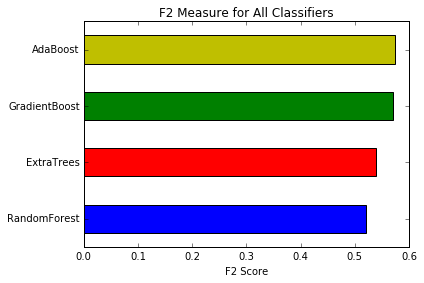

In [154]:
f_scores = f_score_summary(scorers)
ax = f_scores.loc['F2'].plot(kind='barh', title='F2 Measure for All Classifiers', color=['b', 'r', 'g', 'y'])
ax.set_xlabel('F2 Score')
plt.tight_layout()
plt.savefig('img/f2_score.png')

Summarise the F scores

In [155]:
f_scores = f_score_summary(scorers)
print f_scores.to_latex()
f_scores

\begin{tabular}{lrrrr}
\toprule
{} &  RandomForest &  ExtraTrees &  GradientBoost &  AdaBoost \\
\midrule
F1   &      0.597687 &    0.588262 &       0.624193 &  0.624870 \\
F2   &      0.519876 &    0.539351 &       0.570319 &  0.574151 \\
F0.5 &      0.713685 &    0.656862 &       0.698756 &  0.691422 \\
\bottomrule
\end{tabular}



,RandomForest,ExtraTrees,GradientBoost,AdaBoost
F1,0.597687,0.588262,0.624193,0.624870
F2,0.519876,0.539351,0.570319,0.574151
F0.5,0.713685,0.656862,0.698756,0.691422


## Feature Engineering

Test creating some new features based on combinations of existing ones in the dataset. Cross validate each set of new features to see if it improves performance.

### Binary Features

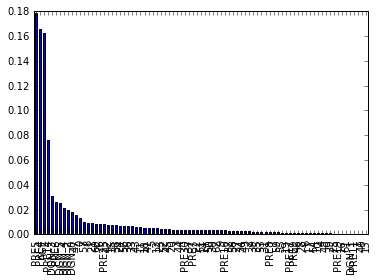

In [156]:
import itertools

def binary_combinations(x_data, names):
    name_pairs = itertools.combinations(names, 2)
    features = []
    for a_name, b_name in name_pairs:
        a, b = x_data[a_name], x_data[b_name]
        features.append(np.logical_xor(a, b).astype(int))
        features.append(np.logical_and(a, b).astype(int))
        features.append(np.logical_or(a, b).astype(int))
        
    return pd.DataFrame(np.array(features).T, index=x_data.index)

binary_features = binary_combinations(Xp, ['PRE7', 'PRE8', 'PRE9', 'PRE10', 'PRE11', 'PRE17', 'PRE30'])
Xp_binary = pd.concat([Xp, binary_features], axis=1)
feature_importance = measure_importance(Xp_binary, Yp)
Xp_binary.drop(feature_importance[feature_importance == 0].index, inplace=True, axis=1)

In [157]:
for model in models:
    model['train_data'] = (Xp_binary, Yp)
    
scorers = pipeline.repeated_cross_fold_validation(models, n=10, k=5)

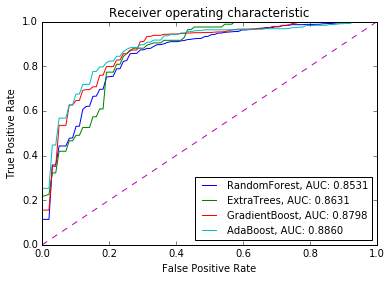

In [158]:
%matplotlib inline
for key, scorer in scorers.iteritems():
    scorer.plot_roc_curve(mean_label=key, mean_line=True, show_all=False)

plt.plot(np.arange(0,1.1, 0.1), np.arange(0,1.1, 0.1), '--')
plt.savefig("img/roc_binary_features.png")

In [159]:
f_scores = f_score_summary(scorers)
print f_scores.to_latex()
f_scores

\begin{tabular}{lrrrr}
\toprule
{} &  RandomForest &  ExtraTrees &  GradientBoost &  AdaBoost \\
\midrule
F1   &      0.532500 &    0.571757 &       0.611276 &  0.652767 \\
F2   &      0.459203 &    0.517610 &       0.543585 &  0.598086 \\
F0.5 &      0.644672 &    0.646104 &       0.707112 &  0.728810 \\
\bottomrule
\end{tabular}



,RandomForest,ExtraTrees,GradientBoost,AdaBoost
F1,0.532500,0.571757,0.611276,0.652767
F2,0.459203,0.517610,0.543585,0.598086
F0.5,0.644672,0.646104,0.707112,0.728810


### Spirometry Based Features

In [160]:
def create_spiro_features(x_data):
    # create new feature FER
    # this is the raito of FEV1 and FVC
    FER = (x_data.PRE5 / x_data.PRE4) * 100
    FER.index = x_data.index

    # create a new feature OBS
    # this is whether the instance has a FER below 70%
    # which implies an obstructive disease.
    OBS = pd.Series(np.zeros(x_data.AGE.shape))
    OBS.index = x_data.index
    OBS.loc[FER < 70] = 1.0
    
    spiro = pd.concat([FER, OBS], axis=1)
    spiro.columns = ['FER', 'OBS']
    return spiro

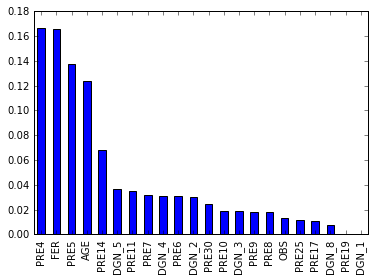

In [161]:
spiro_features = create_spiro_features(Xp)
Xp_spiro = pd.concat([Xp, spiro_features], axis=1)
feature_importance = measure_importance(Xp_spiro, Yp)
Xp_spiro.drop(feature_importance[feature_importance == 0].index, inplace=True, axis=1)

In [162]:
for model in models:
    model['train_data'] = (Xp_spiro, Yp)
    
scorers = pipeline.repeated_cross_fold_validation(models, n=10, k=5)

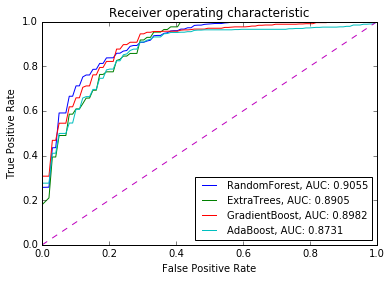

In [163]:
%matplotlib inline
for key, scorer in scorers.iteritems():
    scorer.plot_roc_curve(mean_label=key, mean_line=True, show_all=False)

plt.plot(np.arange(0,1.1, 0.1), np.arange(0,1.1, 0.1), '--')
plt.savefig("img/roc_spiro_features.png")

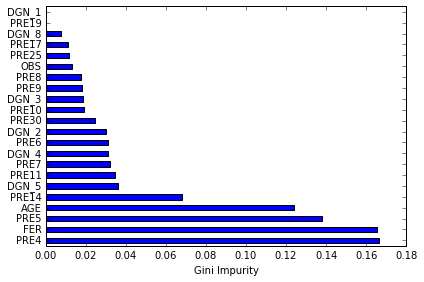

In [164]:
feature_importance.plot(kind='barh')
plt.xlabel('Gini Impurity')
plt.tight_layout()
plt.savefig("img/importance_spiro_features.png")

In [165]:
f_scores = f_score_summary(scorers)
print f_scores.to_latex()
f_scores

\begin{tabular}{lrrrr}
\toprule
{} &  RandomForest &  ExtraTrees &  GradientBoost &  AdaBoost \\
\midrule
F1   &      0.566668 &    0.607952 &       0.601360 &  0.619702 \\
F2   &      0.484577 &    0.562422 &       0.540406 &  0.560452 \\
F0.5 &      0.696171 &    0.670030 &       0.687827 &  0.699803 \\
\bottomrule
\end{tabular}



,RandomForest,ExtraTrees,GradientBoost,AdaBoost
F1,0.566668,0.607952,0.601360,0.619702
F2,0.484577,0.562422,0.540406,0.560452
F0.5,0.696171,0.670030,0.687827,0.699803


### Polynomial Combinations

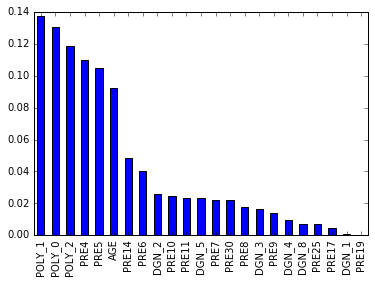

In [166]:
def create_poly_features(x_data, names):
    # create new features base on Polynomials of the original best two predictors
    poly = preprocessing.PolynomialFeatures(2, include_bias=False, interaction_only=True)
    poly_features = pd.DataFrame(poly.fit_transform(x_data[names]), index=x_data.index)
    poly_features.columns = ["POLY_%d" % i for i in poly_features.columns]
    return poly_features

poly_features = create_poly_features(Xp, ['PRE4', 'PRE5'])
Xp_poly = pd.concat([Xp, poly_features], axis=1)
feature_importance = measure_importance(Xp_poly, Yp)
Xp_poly.drop(feature_importance[feature_importance == 0].index, inplace=True, axis=1)

In [167]:
for model in models:
    model['train_data'] = (Xp_poly, Yp)
    
scorers = pipeline.repeated_cross_fold_validation(models, n=10, k=5)

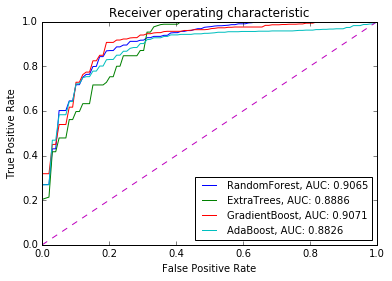

In [168]:
%matplotlib inline
for key, scorer in scorers.iteritems():
    scorer.plot_roc_curve(mean_label=key, mean_line=True, show_all=False)

plt.plot(np.arange(0,1.1, 0.1), np.arange(0,1.1, 0.1), '--')
plt.savefig("img/roc_poly_features.png")

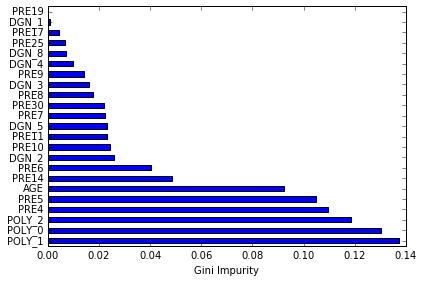

In [169]:
feature_importance.plot(kind='barh')
plt.xlabel('Gini Impurity')
plt.tight_layout()
plt.savefig("img/importance_poly_features.png")

In [170]:
f_scores = f_score_summary(scorers)
print f_scores.to_latex()
f_scores

\begin{tabular}{lrrrr}
\toprule
{} &  RandomForest &  ExtraTrees &  GradientBoost &  AdaBoost \\
\midrule
F1   &      0.596854 &    0.586917 &       0.617784 &  0.658825 \\
F2   &      0.508636 &    0.539122 &       0.563169 &  0.608835 \\
F0.5 &      0.733492 &    0.653059 &       0.692061 &  0.723445 \\
\bottomrule
\end{tabular}



,RandomForest,ExtraTrees,GradientBoost,AdaBoost
F1,0.596854,0.586917,0.617784,0.658825
F2,0.508636,0.539122,0.563169,0.608835
F0.5,0.733492,0.653059,0.692061,0.723445


## Resampling the Dataset

Testing whether using resampling improves performance

### Testing with regular Over/Under sampling

In [43]:
splitter = pipeline.OverUnderSplitter(test_size=0.2, under_sample=0.4, over_sample=0.8)
overunder_scorers = pipeline.monte_carlo_validation(Xp, Yp, models, splitter, n=50)

Determining classes statistics... 2 classes detected: {0: 167, 1: 67}
Over-sampling performed: Counter({0: 167, 1: 120})
Determining classes statistics... 2 classes detected: {0: 167, 1: 120}
Under-sampling performed: Counter({1: 120, 0: 48})
Determining classes statistics... 2 classes detected: {0: 167, 1: 67}
Over-sampling performed: Counter({0: 167, 1: 120})
Determining classes statistics... 2 classes detected: {0: 167, 1: 120}
Under-sampling performed: Counter({1: 120, 0: 48})
Determining classes statistics... 2 classes detected: {0: 167, 1: 67}
Over-sampling performed: Counter({0: 167, 1: 120})
Determining classes statistics... 2 classes detected: {0: 167, 1: 120}
Under-sampling performed: Counter({1: 120, 0: 48})
Determining classes statistics... 2 classes detected: {0: 167, 1: 67}
Over-sampling performed: Counter({0: 167, 1: 120})
Determining classes statistics... 2 classes detected: {0: 167, 1: 120}
Under-sampling performed: Counter({1: 120, 0: 48})
Determining classes statisti

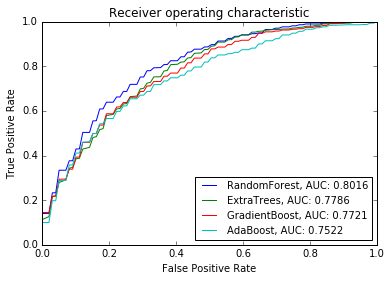

In [45]:
for key, scorer in overunder_scorers.iteritems():
    scorer.plot_roc_curve(mean_label=key, mean_line=True, show_all=False)

In [46]:
f_score_summary(overunder_scorers)

,RandomForest,ExtraTrees,GradientBoost,AdaBoost
F1,0.585699,0.572948,0.568036,0.549260
F2,0.721172,0.711342,0.694270,0.659680
F0.5,0.494029,0.480559,0.481691,0.471805


In [48]:
summarise_scorers(overunder_scorers)

,RandomForest,ExtraTrees,GradientBoost,AdaBoost
count,50.000000,50.000000,50.000000,50.000000
mean,0.801457,0.778529,0.771933,0.752073
std,0.050169,0.056211,0.052979,0.067925
min,0.647059,0.584734,0.620448,0.602241
25%,0.782038,0.745098,0.743347,0.707283
50%,0.805322,0.790266,0.775210,0.752101
75%,0.825980,0.807248,0.803221,0.800420
max,0.885854,0.887255,0.862745,0.886555


### Testing with SMOTE + Undersampling

In [171]:
smote_params = {'kind': 'regular', 'k':3, 'ratio': 0.8, 'verbose': 1}
splitter = pipeline.SMOTESplitter(test_size=0.2, under_sample=1.0, smote_params=smote_params)
smote_scorers = pipeline.monte_carlo_validation(Xp, Yp, models, splitter, n=50)

Determining classes statistics... 2 classes detected: {0: 167, 1: 67}
Finding the 3 nearest neighbours...done!
Creating synthetic samples...Generated 53 new samples ...
done!
Determining classes statistics... 2 classes detected: {0.0: 167, 1.0: 120}
Under-sampling performed: Counter({0.0: 120, 1.0: 120})
Determining classes statistics... 2 classes detected: {0: 167, 1: 67}
Finding the 3 nearest neighbours...done!
Creating synthetic samples...Generated 53 new samples ...
done!
Determining classes statistics... 2 classes detected: {0.0: 167, 1.0: 120}
Under-sampling performed: Counter({0.0: 120, 1.0: 120})
Determining classes statistics... 2 classes detected: {0: 167, 1: 67}
Finding the 3 nearest neighbours...done!
Creating synthetic samples...Generated 53 new samples ...
done!
Determining classes statistics... 2 classes detected: {0.0: 167, 1.0: 120}
Under-sampling performed: Counter({0.0: 120, 1.0: 120})
Determining classes statistics... 2 classes detected: {0: 167, 1: 67}
Finding the 

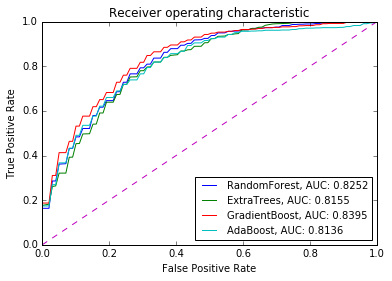

In [172]:
for key, scorer in smote_scorers.iteritems():
    scorer.plot_roc_curve(mean_label=key, mean_line=True, show_all=False)
    
plt.plot(np.arange(0,1.1, 0.1), np.arange(0,1.1, 0.1), '--')
plt.savefig("img/roc_smote.png")

In [173]:
smote_f_scores = f_score_summary(smote_scorers)
print smote_f_scores.to_latex()
smote_f_scores

\begin{tabular}{lrrrr}
\toprule
{} &  RandomForest &  ExtraTrees &  GradientBoost &  AdaBoost \\
\midrule
F1   &      0.608007 &    0.603050 &       0.628132 &  0.609344 \\
F2   &      0.636271 &    0.643457 &       0.652385 &  0.640834 \\
F0.5 &      0.585051 &    0.570976 &       0.608498 &  0.583632 \\
\bottomrule
\end{tabular}



,RandomForest,ExtraTrees,GradientBoost,AdaBoost
F1,0.608007,0.603050,0.628132,0.609344
F2,0.636271,0.643457,0.652385,0.640834
F0.5,0.585051,0.570976,0.608498,0.583632


## Best Classifier

In [199]:
spiro_features = create_spiro_features(Xp)
poly_features = create_poly_features(Xp, ['PRE4', 'PRE5'])
Xp_all = pd.concat([Xp, poly_features, spiro_features], axis=1)
Xp_all.drop(['DGN_1', 'DGN_8'], axis=1, inplace=True)
for model in models:
    model['train_data'] = (Xp_all, Yp)

In [200]:
scorers = pipeline.repeated_cross_fold_validation(models, n=10, k=5)

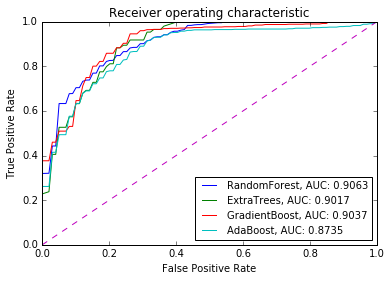

In [201]:
for key, scorer in scorers.iteritems():
    scorer.plot_roc_curve(mean_label=key, mean_line=True, show_all=False)
    
plt.plot(np.arange(0,1.1, 0.1), np.arange(0,1.1, 0.1), '--')

In [202]:
f_scores = f_score_summary(scorers)
f_scores

,RandomForest,ExtraTrees,GradientBoost,AdaBoost
F1,0.557147,0.606021,0.615033,0.621885
F2,0.468675,0.554368,0.554128,0.572426
F0.5,0.702696,0.675303,0.696449,0.685660


## Predicton on Test Set

Finally, based on the best combination of techniques used in the preceeding sections, and using the classifier with the best AUC performance, make probalistic predictions based on the unlabelled test data.

In [207]:
Xtest, _ = preprocess(test, y_data=None)
Xtest = Xtest.drop(['test_id'], axis=1)

test_spiro_features = create_spiro_features(Xtest)
test_poly_features = create_poly_features(Xtest, ['PRE4', 'PRE5'])
Xtest = pd.concat([Xtest, test_spiro_features, test_poly_features], axis=1)

print Xtest.columns.size
print Xp_all.columns.size

24
24


In [224]:
final_model = models[3]['model']
final_model.fit(Xp_all, Yp)
predicted_prob = pd.Series(final_model.predict_proba(Xtest)[:, 1])
predicted_label = pd.Series(final_model.predict(Xtest))

In [225]:
final_submission = pd.concat([test.test_id, predicted_label, predicted_prob], axis=1)
final_submission.columns = ['test_id', 'predicted_label', 'predicted_output']
class_balance_summary(predicted_label)
final_submission

Total number of samples: 100
Number of positive samples: 33
Number of negative samples: 67
Ratio of positive to total number of samples: 0.33


,test_id,predicted_label,predicted_output
0,1,0,0.058904
1,2,0,0.268611
2,3,1,0.623950
3,4,1,0.772251
4,5,1,0.900213
5,6,0,0.270194
6,7,0,0.277577
7,8,0,0.359934
8,9,0,0.180919
9,10,1,0.976232
